In [1]:
import torch
import torch.nn as nn
import os 
import numpy as np
import torch.optim as optim

# from torchvision import datasets, transforms

from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split
import psutil
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
import seaborn as sns
import papermill
import umap
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    classification_report, accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix
)
import pandas as pd


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



/home/marcelino.maita/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Loading Lb vectors from:  ../../../../data/spotify_dataset_sin_duplicados_4.csv


In [3]:
class MLP(nn.Module):
    def __init__(self, capas):
        super(MLP, self).__init__()
        layers = []
        # Capas 
        for i in range(len(capas)-2):
            layers.append(nn.Linear(capas[i], capas[i+1]))
            layers.append(nn.ReLU(inplace=True))
        layers.append(nn.Linear(capas[-2], capas[-1]))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)
        


In [4]:
DATA_PATH ="../../../data"
path_lb_embb = os.path.join(DATA_PATH, f"embbedings_khipu/tfidf_numeric_B.npy")
path_dataset = os.path.join(DATA_PATH, "spotify_dataset_sin_duplicados_4.csv")

## CONFIGURATIONS

TESTING = False
SCALED = True
_EMBEDDINGS = np.load(path_lb_embb , mmap_mode="r")

if TESTING:
    _NROWS = 100
    _EMBEDDINGS = _EMBEDDINGS[:_NROWS]
    _EPHOCS = 10
else:
    _NROWS = None
    _EPHOCS = 1000

if SCALED:
    scaler = MinMaxScaler(feature_range=(0, 1))
    _EMBEDDINGS = scaler.fit_transform(_EMBEDDINGS)

df = pd.read_csv(path_dataset, nrows = _NROWS)
df['Explicit_binary'] = df['Explicit'].map({'Yes': 1, 'No': 0})

X = _EMBEDDINGS

y = df['Explicit_binary']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42 
)

# Convertir data a tensores
# Convertir a tensores
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)  # labels como enteros

X_test_tensor  = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor  = torch.tensor(y_test.values, dtype=torch.long)

# Crear datasets
trainDataset = TensorDataset(X_train_tensor, y_train_tensor)
testDataset  = TensorDataset(X_test_tensor,  y_test_tensor)

trainLoader = DataLoader(trainDataset, batch_size=64, shuffle= True)
testLoader  = DataLoader( testDataset, batch_size=64, shuffle=False)

In [5]:
net = MLP([X_train.shape[1],32, 64,32,1])

In [6]:
# Pasar la red a la GPU
net = net.to(device)

# Loss
# criterion = nn.CrossEntropyLoss()
criterion = nn.BCEWithLogitsLoss()

# Optimizer
optimizer = optim.AdamW(net.parameters(), lr=0.001)

In [7]:
n_epoch = _EPHOCS
train_losses = []
test_losses = []

best_f1_score = 0.0
best_pred = None
best_ephoc = None
best_labels = None

for epoch in range(n_epoch):
    # Training
    net.train()
    total_train_loss = 0
    for embbedings, labels in trainLoader:
        embbedings, labels = embbedings.to(device), labels.to(device).float()

        # Forward
        outputs = net(embbedings).squeeze(1)
        loss = criterion(outputs, labels)

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(trainLoader)
    train_losses.append(avg_train_loss)

    # Evaluation
    net.eval()
    total_test_loss = 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for embbedings, labels in testLoader:
            embbedings, labels = embbedings.to(device), labels.to(device).float()

            outputs = net(embbedings).squeeze(1)
            loss = criterion(outputs, labels)
            total_test_loss += loss.item()

            probs = torch.sigmoid(outputs)
            preds = (probs >= 0.5).int()

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_test_loss = total_test_loss / len(testLoader)
    test_losses.append(avg_test_loss)

    # Accuracy
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds)
    rec = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    if f1 > best_f1_score:
        best_f1_score = f1
        best_pred = all_preds
        best_ephoc = epoch
        best_labels = all_labels.copy()
    print(f"Epoch [{epoch}/{n_epoch}], Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}")

print("Mejores resultados en la época: ", best_ephoc)
print("f1-score", best_f1_score)

Epoch [0/1000], Train Loss: 0.1820, Test Loss: 0.1345


Epoch [1/1000], Train Loss: 0.1158, Test Loss: 0.1256


Epoch [2/1000], Train Loss: 0.0917, Test Loss: 0.1252


Epoch [3/1000], Train Loss: 0.0662, Test Loss: 0.1257


Epoch [4/1000], Train Loss: 0.0435, Test Loss: 0.1573


Epoch [5/1000], Train Loss: 0.0269, Test Loss: 0.1876


Epoch [6/1000], Train Loss: 0.0151, Test Loss: 0.2460


Epoch [7/1000], Train Loss: 0.0091, Test Loss: 0.2679


Epoch [8/1000], Train Loss: 0.0065, Test Loss: 0.3261


Epoch [9/1000], Train Loss: 0.0046, Test Loss: 0.3387


Epoch [10/1000], Train Loss: 0.0037, Test Loss: 0.3317


Epoch [11/1000], Train Loss: 0.0030, Test Loss: 0.3566


Epoch [12/1000], Train Loss: 0.0023, Test Loss: 0.3781


Epoch [13/1000], Train Loss: 0.0022, Test Loss: 0.3972


Epoch [14/1000], Train Loss: 0.0018, Test Loss: 0.4058


Epoch [15/1000], Train Loss: 0.0015, Test Loss: 0.3897


Epoch [16/1000], Train Loss: 0.0021, Test Loss: 0.4053


Epoch [17/1000], Train Loss: 0.0017, Test Loss: 0.3351


Epoch [18/1000], Train Loss: 0.0010, Test Loss: 0.3753


Epoch [19/1000], Train Loss: 0.0012, Test Loss: 0.4136


Epoch [20/1000], Train Loss: 0.0015, Test Loss: 0.3636


Epoch [21/1000], Train Loss: 0.0013, Test Loss: 0.3425


Epoch [22/1000], Train Loss: 0.0003, Test Loss: 0.3926


Epoch [23/1000], Train Loss: 0.0011, Test Loss: 0.3669


Epoch [24/1000], Train Loss: 0.0008, Test Loss: 0.3911


Epoch [25/1000], Train Loss: 0.0003, Test Loss: 0.4141


Epoch [26/1000], Train Loss: 0.0007, Test Loss: 0.3612


Epoch [27/1000], Train Loss: 0.0009, Test Loss: 0.3798


Epoch [28/1000], Train Loss: 0.0007, Test Loss: 0.3414


Epoch [29/1000], Train Loss: 0.0003, Test Loss: 0.3926


Epoch [30/1000], Train Loss: 0.0007, Test Loss: 0.3623


Epoch [31/1000], Train Loss: 0.0007, Test Loss: 0.3836


Epoch [32/1000], Train Loss: 0.0005, Test Loss: 0.3927


Epoch [33/1000], Train Loss: 0.0009, Test Loss: 0.3732


Epoch [34/1000], Train Loss: 0.0008, Test Loss: 0.3739


Epoch [35/1000], Train Loss: 0.0002, Test Loss: 0.3708


Epoch [36/1000], Train Loss: 0.0004, Test Loss: 0.3703


Epoch [37/1000], Train Loss: 0.0005, Test Loss: 0.3785


Epoch [38/1000], Train Loss: 0.0004, Test Loss: 0.3796


Epoch [39/1000], Train Loss: 0.0003, Test Loss: 0.3689


Epoch [40/1000], Train Loss: 0.0001, Test Loss: 0.3850


Epoch [41/1000], Train Loss: 0.0000, Test Loss: 0.4804


Epoch [42/1000], Train Loss: 0.0000, Test Loss: 0.4784


Epoch [43/1000], Train Loss: 0.0000, Test Loss: 0.4830


Epoch [44/1000], Train Loss: 0.0000, Test Loss: 0.4867


Epoch [45/1000], Train Loss: 0.0000, Test Loss: 0.4940


Epoch [46/1000], Train Loss: 0.0000, Test Loss: 0.5037


Epoch [47/1000], Train Loss: 0.0000, Test Loss: 0.5146


Epoch [48/1000], Train Loss: 0.0000, Test Loss: 0.5291


Epoch [49/1000], Train Loss: 0.0000, Test Loss: 0.5522


Epoch [50/1000], Train Loss: 0.0010, Test Loss: 0.4921


Epoch [51/1000], Train Loss: 0.0026, Test Loss: 0.3801


Epoch [52/1000], Train Loss: 0.0009, Test Loss: 0.3607


Epoch [53/1000], Train Loss: 0.0001, Test Loss: 0.3652


Epoch [54/1000], Train Loss: 0.0000, Test Loss: 0.3662


Epoch [55/1000], Train Loss: 0.0000, Test Loss: 0.3811


Epoch [56/1000], Train Loss: 0.0000, Test Loss: 0.3945


Epoch [57/1000], Train Loss: 0.0000, Test Loss: 0.4172


Epoch [58/1000], Train Loss: 0.0014, Test Loss: 0.3620


Epoch [59/1000], Train Loss: 0.0004, Test Loss: 0.3583


Epoch [60/1000], Train Loss: 0.0001, Test Loss: 0.3838


Epoch [61/1000], Train Loss: 0.0002, Test Loss: 0.3592


Epoch [62/1000], Train Loss: 0.0000, Test Loss: 0.3730


Epoch [63/1000], Train Loss: 0.0000, Test Loss: 0.3788


Epoch [64/1000], Train Loss: 0.0000, Test Loss: 0.3928


Epoch [65/1000], Train Loss: 0.0000, Test Loss: 0.4090


Epoch [66/1000], Train Loss: 0.0000, Test Loss: 0.4250


Epoch [67/1000], Train Loss: 0.0000, Test Loss: 0.4401


Epoch [68/1000], Train Loss: 0.0000, Test Loss: 0.4554


Epoch [69/1000], Train Loss: 0.0000, Test Loss: 0.4716


Epoch [70/1000], Train Loss: 0.0000, Test Loss: 0.4905


Epoch [71/1000], Train Loss: 0.0000, Test Loss: 0.5072


Epoch [72/1000], Train Loss: 0.0036, Test Loss: 0.3055


Epoch [73/1000], Train Loss: 0.0010, Test Loss: 0.3037


Epoch [74/1000], Train Loss: 0.0000, Test Loss: 0.3308


Epoch [75/1000], Train Loss: 0.0000, Test Loss: 0.3339


Epoch [76/1000], Train Loss: 0.0000, Test Loss: 0.3425


Epoch [77/1000], Train Loss: 0.0000, Test Loss: 0.3543


Epoch [78/1000], Train Loss: 0.0000, Test Loss: 0.3688


Epoch [79/1000], Train Loss: 0.0000, Test Loss: 0.3838


Epoch [80/1000], Train Loss: 0.0000, Test Loss: 0.3993


Epoch [81/1000], Train Loss: 0.0000, Test Loss: 0.4155


Epoch [82/1000], Train Loss: 0.0000, Test Loss: 0.4347


Epoch [83/1000], Train Loss: 0.0000, Test Loss: 0.4541


Epoch [84/1000], Train Loss: 0.0020, Test Loss: 0.3444


Epoch [85/1000], Train Loss: 0.0015, Test Loss: 0.3227


Epoch [86/1000], Train Loss: 0.0001, Test Loss: 0.3462


Epoch [87/1000], Train Loss: 0.0000, Test Loss: 0.3420


Epoch [88/1000], Train Loss: 0.0000, Test Loss: 0.3474


Epoch [89/1000], Train Loss: 0.0000, Test Loss: 0.3580


Epoch [90/1000], Train Loss: 0.0000, Test Loss: 0.3712


Epoch [91/1000], Train Loss: 0.0000, Test Loss: 0.3863


Epoch [92/1000], Train Loss: 0.0007, Test Loss: 0.3633


Epoch [93/1000], Train Loss: 0.0008, Test Loss: 0.3472


Epoch [94/1000], Train Loss: 0.0002, Test Loss: 0.3425


Epoch [95/1000], Train Loss: 0.0000, Test Loss: 0.3652


Epoch [96/1000], Train Loss: 0.0005, Test Loss: 0.3200


Epoch [97/1000], Train Loss: 0.0007, Test Loss: 0.3226


Epoch [98/1000], Train Loss: 0.0001, Test Loss: 0.3590


Epoch [99/1000], Train Loss: 0.0000, Test Loss: 0.3648


Epoch [100/1000], Train Loss: 0.0000, Test Loss: 0.3676


Epoch [101/1000], Train Loss: 0.0000, Test Loss: 0.3786


Epoch [102/1000], Train Loss: 0.0000, Test Loss: 0.3916


Epoch [103/1000], Train Loss: 0.0000, Test Loss: 0.4065


Epoch [104/1000], Train Loss: 0.0000, Test Loss: 0.4209


Epoch [105/1000], Train Loss: 0.0000, Test Loss: 0.4458


Epoch [106/1000], Train Loss: 0.0013, Test Loss: 0.3556


Epoch [107/1000], Train Loss: 0.0004, Test Loss: 0.3710


Epoch [108/1000], Train Loss: 0.0002, Test Loss: 0.3491


Epoch [109/1000], Train Loss: 0.0000, Test Loss: 0.3548


Epoch [110/1000], Train Loss: 0.0000, Test Loss: 0.3652


Epoch [111/1000], Train Loss: 0.0000, Test Loss: 0.3753


Epoch [112/1000], Train Loss: 0.0000, Test Loss: 0.3889


Epoch [113/1000], Train Loss: 0.0000, Test Loss: 0.4025


Epoch [114/1000], Train Loss: 0.0000, Test Loss: 0.4161


Epoch [115/1000], Train Loss: 0.0000, Test Loss: 0.4310


Epoch [116/1000], Train Loss: 0.0000, Test Loss: 0.4465


Epoch [117/1000], Train Loss: 0.0025, Test Loss: 0.3174


Epoch [118/1000], Train Loss: 0.0008, Test Loss: 0.2883


Epoch [119/1000], Train Loss: 0.0000, Test Loss: 0.3118


Epoch [120/1000], Train Loss: 0.0000, Test Loss: 0.3227


Epoch [121/1000], Train Loss: 0.0000, Test Loss: 0.3376


Epoch [122/1000], Train Loss: 0.0000, Test Loss: 0.3522


Epoch [123/1000], Train Loss: 0.0000, Test Loss: 0.3693


Epoch [124/1000], Train Loss: 0.0000, Test Loss: 0.3876


Epoch [125/1000], Train Loss: 0.0000, Test Loss: 0.4121


Epoch [126/1000], Train Loss: 0.0001, Test Loss: 0.4380


Epoch [127/1000], Train Loss: 0.0013, Test Loss: 0.3476


Epoch [128/1000], Train Loss: 0.0006, Test Loss: 0.3291


Epoch [129/1000], Train Loss: 0.0002, Test Loss: 0.3514


Epoch [130/1000], Train Loss: 0.0000, Test Loss: 0.3522


Epoch [131/1000], Train Loss: 0.0000, Test Loss: 0.3733


Epoch [132/1000], Train Loss: 0.0000, Test Loss: 0.3650


Epoch [133/1000], Train Loss: 0.0000, Test Loss: 0.3751


Epoch [134/1000], Train Loss: 0.0000, Test Loss: 0.3883


Epoch [135/1000], Train Loss: 0.0000, Test Loss: 0.4024


Epoch [136/1000], Train Loss: 0.0000, Test Loss: 0.4179


Epoch [137/1000], Train Loss: 0.0000, Test Loss: 0.4350


Epoch [138/1000], Train Loss: 0.0000, Test Loss: 0.4517


Epoch [139/1000], Train Loss: 0.0000, Test Loss: 0.4687


Epoch [140/1000], Train Loss: 0.0000, Test Loss: 0.4865


Epoch [141/1000], Train Loss: 0.0004, Test Loss: 0.4448


Epoch [142/1000], Train Loss: 0.0013, Test Loss: 0.3676


Epoch [143/1000], Train Loss: 0.0001, Test Loss: 0.3619


Epoch [144/1000], Train Loss: 0.0000, Test Loss: 0.3660


Epoch [145/1000], Train Loss: 0.0000, Test Loss: 0.3663


Epoch [146/1000], Train Loss: 0.0000, Test Loss: 0.3688


Epoch [147/1000], Train Loss: 0.0000, Test Loss: 0.3767


Epoch [148/1000], Train Loss: 0.0000, Test Loss: 0.3870


Epoch [149/1000], Train Loss: 0.0000, Test Loss: 0.4000


Epoch [150/1000], Train Loss: 0.0000, Test Loss: 0.4134


Epoch [151/1000], Train Loss: 0.0000, Test Loss: 0.4278


Epoch [152/1000], Train Loss: 0.0000, Test Loss: 0.4416


Epoch [153/1000], Train Loss: 0.0000, Test Loss: 0.4545


Epoch [154/1000], Train Loss: 0.0000, Test Loss: 0.4663


Epoch [155/1000], Train Loss: 0.0015, Test Loss: 0.3793


Epoch [156/1000], Train Loss: 0.0018, Test Loss: 0.3013


Epoch [157/1000], Train Loss: 0.0000, Test Loss: 0.3114


Epoch [158/1000], Train Loss: 0.0000, Test Loss: 0.3201


Epoch [159/1000], Train Loss: 0.0000, Test Loss: 0.3287


Epoch [160/1000], Train Loss: 0.0000, Test Loss: 0.3419


Epoch [161/1000], Train Loss: 0.0000, Test Loss: 0.3561


Epoch [162/1000], Train Loss: 0.0000, Test Loss: 0.3721


Epoch [163/1000], Train Loss: 0.0004, Test Loss: 0.5641


Epoch [164/1000], Train Loss: 0.0008, Test Loss: 0.3424


Epoch [165/1000], Train Loss: 0.0001, Test Loss: 0.4038


Epoch [166/1000], Train Loss: 0.0001, Test Loss: 0.3658


Epoch [167/1000], Train Loss: 0.0006, Test Loss: 0.3394


Epoch [168/1000], Train Loss: 0.0003, Test Loss: 0.3532


Epoch [169/1000], Train Loss: 0.0000, Test Loss: 0.3570


Epoch [170/1000], Train Loss: 0.0000, Test Loss: 0.3659


Epoch [171/1000], Train Loss: 0.0000, Test Loss: 0.3790


Epoch [172/1000], Train Loss: 0.0000, Test Loss: 0.3949


Epoch [173/1000], Train Loss: 0.0000, Test Loss: 0.4128


Epoch [174/1000], Train Loss: 0.0000, Test Loss: 0.4488


Epoch [175/1000], Train Loss: 0.0004, Test Loss: 0.4387


Epoch [176/1000], Train Loss: 0.0014, Test Loss: 0.3280


Epoch [177/1000], Train Loss: 0.0007, Test Loss: 0.3308


Epoch [178/1000], Train Loss: 0.0002, Test Loss: 0.3520


Epoch [179/1000], Train Loss: 0.0000, Test Loss: 0.3668


Epoch [180/1000], Train Loss: 0.0000, Test Loss: 0.3813


Epoch [181/1000], Train Loss: 0.0000, Test Loss: 0.3987


Epoch [182/1000], Train Loss: 0.0000, Test Loss: 0.4147


Epoch [183/1000], Train Loss: 0.0000, Test Loss: 0.4299


Epoch [184/1000], Train Loss: 0.0000, Test Loss: 0.4464


Epoch [185/1000], Train Loss: 0.0000, Test Loss: 0.4653


Epoch [186/1000], Train Loss: 0.0009, Test Loss: 0.4193


Epoch [187/1000], Train Loss: 0.0017, Test Loss: 0.3040


Epoch [188/1000], Train Loss: 0.0006, Test Loss: 0.3107


Epoch [189/1000], Train Loss: 0.0001, Test Loss: 0.3542


Epoch [190/1000], Train Loss: 0.0000, Test Loss: 0.3646


Epoch [191/1000], Train Loss: 0.0000, Test Loss: 0.3746


Epoch [192/1000], Train Loss: 0.0000, Test Loss: 0.3880


Epoch [193/1000], Train Loss: 0.0000, Test Loss: 0.4021


Epoch [194/1000], Train Loss: 0.0000, Test Loss: 0.4196


Epoch [195/1000], Train Loss: 0.0000, Test Loss: 0.4367


Epoch [196/1000], Train Loss: 0.0000, Test Loss: 0.4540


Epoch [197/1000], Train Loss: 0.0000, Test Loss: 0.4718


Epoch [198/1000], Train Loss: 0.0000, Test Loss: 0.4878


Epoch [199/1000], Train Loss: 0.0000, Test Loss: 0.5143


Epoch [200/1000], Train Loss: 0.0006, Test Loss: 0.5860


Epoch [201/1000], Train Loss: 0.0011, Test Loss: 0.4715


Epoch [202/1000], Train Loss: 0.0005, Test Loss: 0.4230


Epoch [203/1000], Train Loss: 0.0004, Test Loss: 0.3659


Epoch [204/1000], Train Loss: 0.0000, Test Loss: 0.3687


Epoch [205/1000], Train Loss: 0.0000, Test Loss: 0.3639


Epoch [206/1000], Train Loss: 0.0000, Test Loss: 0.3681


Epoch [207/1000], Train Loss: 0.0000, Test Loss: 0.3748


Epoch [208/1000], Train Loss: 0.0000, Test Loss: 0.3907


Epoch [209/1000], Train Loss: 0.0000, Test Loss: 0.4026


Epoch [210/1000], Train Loss: 0.0000, Test Loss: 0.4179


Epoch [211/1000], Train Loss: 0.0000, Test Loss: 0.4320


Epoch [212/1000], Train Loss: 0.0000, Test Loss: 0.4459


Epoch [213/1000], Train Loss: 0.0000, Test Loss: 0.4599


Epoch [214/1000], Train Loss: 0.0000, Test Loss: 0.4729


Epoch [215/1000], Train Loss: 0.0000, Test Loss: 0.4862


Epoch [216/1000], Train Loss: 0.0000, Test Loss: 0.4962


Epoch [217/1000], Train Loss: 0.0010, Test Loss: 0.4639


Epoch [218/1000], Train Loss: 0.0015, Test Loss: 0.3511


Epoch [219/1000], Train Loss: 0.0003, Test Loss: 0.3484


Epoch [220/1000], Train Loss: 0.0001, Test Loss: 0.3475


Epoch [221/1000], Train Loss: 0.0000, Test Loss: 0.3786


Epoch [222/1000], Train Loss: 0.0000, Test Loss: 0.3553


Epoch [223/1000], Train Loss: 0.0000, Test Loss: 0.3622


Epoch [224/1000], Train Loss: 0.0000, Test Loss: 0.3719


Epoch [225/1000], Train Loss: 0.0000, Test Loss: 0.3857


Epoch [226/1000], Train Loss: 0.0000, Test Loss: 0.3997


Epoch [227/1000], Train Loss: 0.0000, Test Loss: 0.4162


Epoch [228/1000], Train Loss: 0.0004, Test Loss: 0.4136


Epoch [229/1000], Train Loss: 0.0012, Test Loss: 0.3450


Epoch [230/1000], Train Loss: 0.0004, Test Loss: 0.3499


Epoch [231/1000], Train Loss: 0.0002, Test Loss: 0.3262


Epoch [232/1000], Train Loss: 0.0000, Test Loss: 0.3332


Epoch [233/1000], Train Loss: 0.0000, Test Loss: 0.3400


Epoch [234/1000], Train Loss: 0.0000, Test Loss: 0.3517


Epoch [235/1000], Train Loss: 0.0000, Test Loss: 0.3657


Epoch [236/1000], Train Loss: 0.0000, Test Loss: 0.3811


Epoch [237/1000], Train Loss: 0.0000, Test Loss: 0.3964


Epoch [238/1000], Train Loss: 0.0000, Test Loss: 0.4111


Epoch [239/1000], Train Loss: 0.0000, Test Loss: 0.4257


Epoch [240/1000], Train Loss: 0.0000, Test Loss: 0.4415


Epoch [241/1000], Train Loss: 0.0000, Test Loss: 0.4536


Epoch [242/1000], Train Loss: 0.0000, Test Loss: 0.4672


Epoch [243/1000], Train Loss: 0.0000, Test Loss: 0.4790


Epoch [244/1000], Train Loss: 0.0000, Test Loss: 0.4908


Epoch [245/1000], Train Loss: 0.0000, Test Loss: 0.4998


Epoch [246/1000], Train Loss: 0.0000, Test Loss: 0.5081


Epoch [247/1000], Train Loss: 0.0000, Test Loss: 0.5157


Epoch [248/1000], Train Loss: 0.0000, Test Loss: 0.5236


Epoch [249/1000], Train Loss: 0.0000, Test Loss: 0.5302


Epoch [250/1000], Train Loss: 0.0000, Test Loss: 0.5319


Epoch [251/1000], Train Loss: 0.0000, Test Loss: 0.5276


Epoch [252/1000], Train Loss: 0.0011, Test Loss: 0.4775


Epoch [253/1000], Train Loss: 0.0024, Test Loss: 0.3521


Epoch [254/1000], Train Loss: 0.0003, Test Loss: 0.3326


Epoch [255/1000], Train Loss: 0.0003, Test Loss: 0.3276


Epoch [256/1000], Train Loss: 0.0001, Test Loss: 0.3401


Epoch [257/1000], Train Loss: 0.0003, Test Loss: 0.3269


Epoch [258/1000], Train Loss: 0.0000, Test Loss: 0.3458


Epoch [259/1000], Train Loss: 0.0000, Test Loss: 0.3389


Epoch [260/1000], Train Loss: 0.0000, Test Loss: 0.3397


Epoch [261/1000], Train Loss: 0.0000, Test Loss: 0.3476


Epoch [262/1000], Train Loss: 0.0000, Test Loss: 0.3576


Epoch [263/1000], Train Loss: 0.0007, Test Loss: 0.3657


Epoch [264/1000], Train Loss: 0.0018, Test Loss: 0.2855


Epoch [265/1000], Train Loss: 0.0005, Test Loss: 0.2986


Epoch [266/1000], Train Loss: 0.0002, Test Loss: 0.2835


Epoch [267/1000], Train Loss: 0.0000, Test Loss: 0.3079


Epoch [268/1000], Train Loss: 0.0000, Test Loss: 0.3211


Epoch [269/1000], Train Loss: 0.0000, Test Loss: 0.3356


Epoch [270/1000], Train Loss: 0.0000, Test Loss: 0.3500


Epoch [271/1000], Train Loss: 0.0000, Test Loss: 0.3649


Epoch [272/1000], Train Loss: 0.0000, Test Loss: 0.3803


Epoch [273/1000], Train Loss: 0.0000, Test Loss: 0.3960


Epoch [274/1000], Train Loss: 0.0000, Test Loss: 0.4190


Epoch [275/1000], Train Loss: 0.0000, Test Loss: 0.4474


Epoch [276/1000], Train Loss: 0.0000, Test Loss: 0.4527


Epoch [277/1000], Train Loss: 0.0000, Test Loss: 0.4594


Epoch [278/1000], Train Loss: 0.0000, Test Loss: 0.4680


Epoch [279/1000], Train Loss: 0.0000, Test Loss: 0.4783


Epoch [280/1000], Train Loss: 0.0000, Test Loss: 0.4863


Epoch [281/1000], Train Loss: 0.0000, Test Loss: 0.4961


Epoch [282/1000], Train Loss: 0.0000, Test Loss: 0.5246


Epoch [283/1000], Train Loss: 0.0039, Test Loss: 0.3036


Epoch [284/1000], Train Loss: 0.0007, Test Loss: 0.2851


Epoch [285/1000], Train Loss: 0.0000, Test Loss: 0.2951


Epoch [286/1000], Train Loss: 0.0000, Test Loss: 0.3002


Epoch [287/1000], Train Loss: 0.0000, Test Loss: 0.3087


Epoch [288/1000], Train Loss: 0.0000, Test Loss: 0.3205


Epoch [289/1000], Train Loss: 0.0000, Test Loss: 0.3345


Epoch [290/1000], Train Loss: 0.0000, Test Loss: 0.3490


Epoch [291/1000], Train Loss: 0.0000, Test Loss: 0.3637


Epoch [292/1000], Train Loss: 0.0000, Test Loss: 0.3785


Epoch [293/1000], Train Loss: 0.0000, Test Loss: 0.3937


Epoch [294/1000], Train Loss: 0.0000, Test Loss: 0.4090


Epoch [295/1000], Train Loss: 0.0000, Test Loss: 0.4390


Epoch [296/1000], Train Loss: 0.0034, Test Loss: 0.2704


Epoch [297/1000], Train Loss: 0.0011, Test Loss: 0.2786


Epoch [298/1000], Train Loss: 0.0000, Test Loss: 0.2958


Epoch [299/1000], Train Loss: 0.0000, Test Loss: 0.3035


Epoch [300/1000], Train Loss: 0.0000, Test Loss: 0.3119


Epoch [301/1000], Train Loss: 0.0000, Test Loss: 0.3241


Epoch [302/1000], Train Loss: 0.0000, Test Loss: 0.3382


Epoch [303/1000], Train Loss: 0.0000, Test Loss: 0.3537


Epoch [304/1000], Train Loss: 0.0000, Test Loss: 0.3687


Epoch [305/1000], Train Loss: 0.0000, Test Loss: 0.3841


Epoch [306/1000], Train Loss: 0.0000, Test Loss: 0.3986


Epoch [307/1000], Train Loss: 0.0000, Test Loss: 0.4164


Epoch [308/1000], Train Loss: 0.0009, Test Loss: 0.3842


Epoch [309/1000], Train Loss: 0.0008, Test Loss: 0.3281


Epoch [310/1000], Train Loss: 0.0000, Test Loss: 0.3343


Epoch [311/1000], Train Loss: 0.0000, Test Loss: 0.3409


Epoch [312/1000], Train Loss: 0.0002, Test Loss: 0.3176


Epoch [313/1000], Train Loss: 0.0000, Test Loss: 0.3483


Epoch [314/1000], Train Loss: 0.0000, Test Loss: 0.3479


Epoch [315/1000], Train Loss: 0.0000, Test Loss: 0.3522


Epoch [316/1000], Train Loss: 0.0000, Test Loss: 0.3613


Epoch [317/1000], Train Loss: 0.0000, Test Loss: 0.3735


Epoch [318/1000], Train Loss: 0.0000, Test Loss: 0.3870


Epoch [319/1000], Train Loss: 0.0000, Test Loss: 0.4026


Epoch [320/1000], Train Loss: 0.0000, Test Loss: 0.4165


Epoch [321/1000], Train Loss: 0.0000, Test Loss: 0.4309


Epoch [322/1000], Train Loss: 0.0000, Test Loss: 0.4449


Epoch [323/1000], Train Loss: 0.0000, Test Loss: 0.4569


Epoch [324/1000], Train Loss: 0.0000, Test Loss: 0.4696


Epoch [325/1000], Train Loss: 0.0006, Test Loss: 0.4370


Epoch [326/1000], Train Loss: 0.0031, Test Loss: 0.2980


Epoch [327/1000], Train Loss: 0.0004, Test Loss: 0.2973


Epoch [328/1000], Train Loss: 0.0000, Test Loss: 0.3140


Epoch [329/1000], Train Loss: 0.0000, Test Loss: 0.3191


Epoch [330/1000], Train Loss: 0.0000, Test Loss: 0.3261


Epoch [331/1000], Train Loss: 0.0000, Test Loss: 0.3370


Epoch [332/1000], Train Loss: 0.0000, Test Loss: 0.3499


Epoch [333/1000], Train Loss: 0.0000, Test Loss: 0.3660


Epoch [334/1000], Train Loss: 0.0000, Test Loss: 0.3800


Epoch [335/1000], Train Loss: 0.0000, Test Loss: 0.3943


Epoch [336/1000], Train Loss: 0.0000, Test Loss: 0.4095


Epoch [337/1000], Train Loss: 0.0000, Test Loss: 0.4245


Epoch [338/1000], Train Loss: 0.0000, Test Loss: 0.4388


Epoch [339/1000], Train Loss: 0.0000, Test Loss: 0.4521


Epoch [340/1000], Train Loss: 0.0000, Test Loss: 0.4647


Epoch [341/1000], Train Loss: 0.0000, Test Loss: 0.4767


Epoch [342/1000], Train Loss: 0.0000, Test Loss: 0.4852


Epoch [343/1000], Train Loss: 0.0000, Test Loss: 0.4930


Epoch [344/1000], Train Loss: 0.0000, Test Loss: 0.4997


Epoch [345/1000], Train Loss: 0.0000, Test Loss: 0.5039


Epoch [346/1000], Train Loss: 0.0022, Test Loss: 0.3732


Epoch [347/1000], Train Loss: 0.0044, Test Loss: 0.2664


Epoch [348/1000], Train Loss: 0.0010, Test Loss: 0.2731


Epoch [349/1000], Train Loss: 0.0001, Test Loss: 0.2909


Epoch [350/1000], Train Loss: 0.0000, Test Loss: 0.2965


Epoch [351/1000], Train Loss: 0.0000, Test Loss: 0.3067


Epoch [352/1000], Train Loss: 0.0000, Test Loss: 0.3183


Epoch [353/1000], Train Loss: 0.0000, Test Loss: 0.3334


Epoch [354/1000], Train Loss: 0.0000, Test Loss: 0.3485


Epoch [355/1000], Train Loss: 0.0000, Test Loss: 0.3637


Epoch [356/1000], Train Loss: 0.0000, Test Loss: 0.3797


Epoch [357/1000], Train Loss: 0.0000, Test Loss: 0.3959


Epoch [358/1000], Train Loss: 0.0000, Test Loss: 0.4109


Epoch [359/1000], Train Loss: 0.0000, Test Loss: 0.4254


Epoch [360/1000], Train Loss: 0.0000, Test Loss: 0.4412


Epoch [361/1000], Train Loss: 0.0000, Test Loss: 0.4531


Epoch [362/1000], Train Loss: 0.0000, Test Loss: 0.4646


Epoch [363/1000], Train Loss: 0.0000, Test Loss: 0.4755


Epoch [364/1000], Train Loss: 0.0000, Test Loss: 0.4839


Epoch [365/1000], Train Loss: 0.0000, Test Loss: 0.4903


Epoch [366/1000], Train Loss: 0.0000, Test Loss: 0.4928


Epoch [367/1000], Train Loss: 0.0007, Test Loss: 0.4495


Epoch [368/1000], Train Loss: 0.0071, Test Loss: 0.2266


Epoch [369/1000], Train Loss: 0.0005, Test Loss: 0.2613


Epoch [370/1000], Train Loss: 0.0000, Test Loss: 0.2766


Epoch [371/1000], Train Loss: 0.0000, Test Loss: 0.2859


Epoch [372/1000], Train Loss: 0.0000, Test Loss: 0.2990


Epoch [373/1000], Train Loss: 0.0000, Test Loss: 0.3135


Epoch [374/1000], Train Loss: 0.0000, Test Loss: 0.3286


Epoch [375/1000], Train Loss: 0.0000, Test Loss: 0.3448


Epoch [376/1000], Train Loss: 0.0000, Test Loss: 0.3608


Epoch [377/1000], Train Loss: 0.0000, Test Loss: 0.3763


Epoch [378/1000], Train Loss: 0.0000, Test Loss: 0.3933


Epoch [379/1000], Train Loss: 0.0021, Test Loss: 0.2932


Epoch [380/1000], Train Loss: 0.0009, Test Loss: 0.2919


Epoch [381/1000], Train Loss: 0.0001, Test Loss: 0.3176


Epoch [382/1000], Train Loss: 0.0000, Test Loss: 0.3361


Epoch [383/1000], Train Loss: 0.0003, Test Loss: 0.3294


Epoch [384/1000], Train Loss: 0.0000, Test Loss: 0.3428


Epoch [385/1000], Train Loss: 0.0000, Test Loss: 0.3491


Epoch [386/1000], Train Loss: 0.0000, Test Loss: 0.3592


Epoch [387/1000], Train Loss: 0.0000, Test Loss: 0.3734


Epoch [388/1000], Train Loss: 0.0000, Test Loss: 0.3885


Epoch [389/1000], Train Loss: 0.0000, Test Loss: 0.4041


Epoch [390/1000], Train Loss: 0.0000, Test Loss: 0.4200


Epoch [391/1000], Train Loss: 0.0000, Test Loss: 0.4355


Epoch [392/1000], Train Loss: 0.0000, Test Loss: 0.4519


Epoch [393/1000], Train Loss: 0.0012, Test Loss: 0.3657


Epoch [394/1000], Train Loss: 0.0009, Test Loss: 0.3306


Epoch [395/1000], Train Loss: 0.0004, Test Loss: 0.3080


Epoch [396/1000], Train Loss: 0.0002, Test Loss: 0.3223


Epoch [397/1000], Train Loss: 0.0002, Test Loss: 0.3296


Epoch [398/1000], Train Loss: 0.0000, Test Loss: 0.3358


Epoch [399/1000], Train Loss: 0.0000, Test Loss: 0.3442


Epoch [400/1000], Train Loss: 0.0000, Test Loss: 0.3538


Epoch [401/1000], Train Loss: 0.0000, Test Loss: 0.3672


Epoch [402/1000], Train Loss: 0.0000, Test Loss: 0.3818


Epoch [403/1000], Train Loss: 0.0000, Test Loss: 0.3964


Epoch [404/1000], Train Loss: 0.0000, Test Loss: 0.4120


Epoch [405/1000], Train Loss: 0.0000, Test Loss: 0.4273


Epoch [406/1000], Train Loss: 0.0000, Test Loss: 0.4387


Epoch [407/1000], Train Loss: 0.0000, Test Loss: 0.4535


Epoch [408/1000], Train Loss: 0.0000, Test Loss: 0.4680


Epoch [409/1000], Train Loss: 0.0026, Test Loss: 0.2957


Epoch [410/1000], Train Loss: 0.0005, Test Loss: 0.3304


Epoch [411/1000], Train Loss: 0.0000, Test Loss: 0.3288


Epoch [412/1000], Train Loss: 0.0000, Test Loss: 0.3296


Epoch [413/1000], Train Loss: 0.0000, Test Loss: 0.3348


Epoch [414/1000], Train Loss: 0.0000, Test Loss: 0.3431


Epoch [415/1000], Train Loss: 0.0000, Test Loss: 0.3557


Epoch [416/1000], Train Loss: 0.0000, Test Loss: 0.3677


Epoch [417/1000], Train Loss: 0.0000, Test Loss: 0.3817


Epoch [418/1000], Train Loss: 0.0000, Test Loss: 0.3958


Epoch [419/1000], Train Loss: 0.0000, Test Loss: 0.4100


Epoch [420/1000], Train Loss: 0.0000, Test Loss: 0.4221


Epoch [421/1000], Train Loss: 0.0000, Test Loss: 0.4344


Epoch [422/1000], Train Loss: 0.0019, Test Loss: 0.3075


Epoch [423/1000], Train Loss: 0.0015, Test Loss: 0.2547


Epoch [424/1000], Train Loss: 0.0003, Test Loss: 0.2702


Epoch [425/1000], Train Loss: 0.0001, Test Loss: 0.3111


Epoch [426/1000], Train Loss: 0.0000, Test Loss: 0.3250


Epoch [427/1000], Train Loss: 0.0000, Test Loss: 0.3396


Epoch [428/1000], Train Loss: 0.0000, Test Loss: 0.3547


Epoch [429/1000], Train Loss: 0.0000, Test Loss: 0.3707


Epoch [430/1000], Train Loss: 0.0000, Test Loss: 0.3869


Epoch [431/1000], Train Loss: 0.0000, Test Loss: 0.4033


Epoch [432/1000], Train Loss: 0.0000, Test Loss: 0.4185


Epoch [433/1000], Train Loss: 0.0000, Test Loss: 0.4335


Epoch [434/1000], Train Loss: 0.0000, Test Loss: 0.4481


Epoch [435/1000], Train Loss: 0.0000, Test Loss: 0.4622


Epoch [436/1000], Train Loss: 0.0007, Test Loss: 0.5482


Epoch [437/1000], Train Loss: 0.0017, Test Loss: 0.3498


Epoch [438/1000], Train Loss: 0.0002, Test Loss: 0.3532


Epoch [439/1000], Train Loss: 0.0002, Test Loss: 0.3500


Epoch [440/1000], Train Loss: 0.0000, Test Loss: 0.3431


Epoch [441/1000], Train Loss: 0.0000, Test Loss: 0.3469


Epoch [442/1000], Train Loss: 0.0000, Test Loss: 0.3506


Epoch [443/1000], Train Loss: 0.0000, Test Loss: 0.3580


Epoch [444/1000], Train Loss: 0.0000, Test Loss: 0.3695


Epoch [445/1000], Train Loss: 0.0000, Test Loss: 0.3792


Epoch [446/1000], Train Loss: 0.0000, Test Loss: 0.3927


Epoch [447/1000], Train Loss: 0.0000, Test Loss: 0.4045


Epoch [448/1000], Train Loss: 0.0000, Test Loss: 0.4169


Epoch [449/1000], Train Loss: 0.0000, Test Loss: 0.4300


Epoch [450/1000], Train Loss: 0.0000, Test Loss: 0.4425


Epoch [451/1000], Train Loss: 0.0000, Test Loss: 0.4565


Epoch [452/1000], Train Loss: 0.0000, Test Loss: 0.4689


Epoch [453/1000], Train Loss: 0.0019, Test Loss: 0.3760


Epoch [454/1000], Train Loss: 0.0012, Test Loss: 0.3109


Epoch [455/1000], Train Loss: 0.0001, Test Loss: 0.3127


Epoch [456/1000], Train Loss: 0.0000, Test Loss: 0.3194


Epoch [457/1000], Train Loss: 0.0000, Test Loss: 0.3187


Epoch [458/1000], Train Loss: 0.0000, Test Loss: 0.3246


Epoch [459/1000], Train Loss: 0.0000, Test Loss: 0.3338


Epoch [460/1000], Train Loss: 0.0000, Test Loss: 0.3466


Epoch [461/1000], Train Loss: 0.0000, Test Loss: 0.3595


Epoch [462/1000], Train Loss: 0.0000, Test Loss: 0.3730


Epoch [463/1000], Train Loss: 0.0000, Test Loss: 0.3874


Epoch [464/1000], Train Loss: 0.0000, Test Loss: 0.3999


Epoch [465/1000], Train Loss: 0.0000, Test Loss: 0.4140


Epoch [466/1000], Train Loss: 0.0000, Test Loss: 0.4308


Epoch [467/1000], Train Loss: 0.0000, Test Loss: 0.4492


Epoch [468/1000], Train Loss: 0.0000, Test Loss: 0.4590


Epoch [469/1000], Train Loss: 0.0000, Test Loss: 0.4613


Epoch [470/1000], Train Loss: 0.0000, Test Loss: 0.4680


Epoch [471/1000], Train Loss: 0.0000, Test Loss: 0.4737


Epoch [472/1000], Train Loss: 0.0000, Test Loss: 0.4786


Epoch [473/1000], Train Loss: 0.0000, Test Loss: 0.4845


Epoch [474/1000], Train Loss: 0.0000, Test Loss: 0.4828


Epoch [475/1000], Train Loss: 0.0020, Test Loss: 0.3739


Epoch [476/1000], Train Loss: 0.0022, Test Loss: 0.3135


Epoch [477/1000], Train Loss: 0.0004, Test Loss: 0.3195


Epoch [478/1000], Train Loss: 0.0001, Test Loss: 0.3187


Epoch [479/1000], Train Loss: 0.0000, Test Loss: 0.3190


Epoch [480/1000], Train Loss: 0.0000, Test Loss: 0.3205


Epoch [481/1000], Train Loss: 0.0000, Test Loss: 0.3253


Epoch [482/1000], Train Loss: 0.0000, Test Loss: 0.3337


Epoch [483/1000], Train Loss: 0.0000, Test Loss: 0.3439


Epoch [484/1000], Train Loss: 0.0000, Test Loss: 0.3544


Epoch [485/1000], Train Loss: 0.0000, Test Loss: 0.3656


Epoch [486/1000], Train Loss: 0.0000, Test Loss: 0.3782


Epoch [487/1000], Train Loss: 0.0000, Test Loss: 0.3921


Epoch [488/1000], Train Loss: 0.0000, Test Loss: 0.4103


Epoch [489/1000], Train Loss: 0.0035, Test Loss: 0.2853


Epoch [490/1000], Train Loss: 0.0008, Test Loss: 0.2714


Epoch [491/1000], Train Loss: 0.0001, Test Loss: 0.2897


Epoch [492/1000], Train Loss: 0.0000, Test Loss: 0.2966


Epoch [493/1000], Train Loss: 0.0000, Test Loss: 0.3061


Epoch [494/1000], Train Loss: 0.0000, Test Loss: 0.3181


Epoch [495/1000], Train Loss: 0.0000, Test Loss: 0.3289


Epoch [496/1000], Train Loss: 0.0000, Test Loss: 0.3446


Epoch [497/1000], Train Loss: 0.0000, Test Loss: 0.3603


Epoch [498/1000], Train Loss: 0.0000, Test Loss: 0.3814


Epoch [499/1000], Train Loss: 0.0016, Test Loss: 0.2866


Epoch [500/1000], Train Loss: 0.0020, Test Loss: 0.2539


Epoch [501/1000], Train Loss: 0.0004, Test Loss: 0.2836


Epoch [502/1000], Train Loss: 0.0000, Test Loss: 0.2925


Epoch [503/1000], Train Loss: 0.0000, Test Loss: 0.3054


Epoch [504/1000], Train Loss: 0.0000, Test Loss: 0.3193


Epoch [505/1000], Train Loss: 0.0000, Test Loss: 0.3352


Epoch [506/1000], Train Loss: 0.0000, Test Loss: 0.3507


Epoch [507/1000], Train Loss: 0.0000, Test Loss: 0.3667


Epoch [508/1000], Train Loss: 0.0000, Test Loss: 0.3829


Epoch [509/1000], Train Loss: 0.0000, Test Loss: 0.3984


Epoch [510/1000], Train Loss: 0.0000, Test Loss: 0.4148


Epoch [511/1000], Train Loss: 0.0000, Test Loss: 0.4318


Epoch [512/1000], Train Loss: 0.0000, Test Loss: 0.4623


Epoch [513/1000], Train Loss: 0.0036, Test Loss: 0.2218


Epoch [514/1000], Train Loss: 0.0046, Test Loss: 0.1986


Epoch [515/1000], Train Loss: 0.0004, Test Loss: 0.2790


Epoch [516/1000], Train Loss: 0.0001, Test Loss: 0.2950


Epoch [517/1000], Train Loss: 0.0000, Test Loss: 0.3145


Epoch [518/1000], Train Loss: 0.0000, Test Loss: 0.3337


Epoch [519/1000], Train Loss: 0.0000, Test Loss: 0.3516


Epoch [520/1000], Train Loss: 0.0000, Test Loss: 0.3707


Epoch [521/1000], Train Loss: 0.0000, Test Loss: 0.3894


Epoch [522/1000], Train Loss: 0.0000, Test Loss: 0.4096


Epoch [523/1000], Train Loss: 0.0000, Test Loss: 0.4258


Epoch [524/1000], Train Loss: 0.0000, Test Loss: 0.4420


Epoch [525/1000], Train Loss: 0.0000, Test Loss: 0.4583


Epoch [526/1000], Train Loss: 0.0000, Test Loss: 0.4735


Epoch [527/1000], Train Loss: 0.0000, Test Loss: 0.4902


Epoch [528/1000], Train Loss: 0.0025, Test Loss: 0.2577


Epoch [529/1000], Train Loss: 0.0014, Test Loss: 0.2648


Epoch [530/1000], Train Loss: 0.0000, Test Loss: 0.2874


Epoch [531/1000], Train Loss: 0.0000, Test Loss: 0.3006


Epoch [532/1000], Train Loss: 0.0000, Test Loss: 0.3142


Epoch [533/1000], Train Loss: 0.0000, Test Loss: 0.3301


Epoch [534/1000], Train Loss: 0.0000, Test Loss: 0.3475


Epoch [535/1000], Train Loss: 0.0000, Test Loss: 0.3649


Epoch [536/1000], Train Loss: 0.0000, Test Loss: 0.3832


Epoch [537/1000], Train Loss: 0.0000, Test Loss: 0.4010


Epoch [538/1000], Train Loss: 0.0000, Test Loss: 0.4276


Epoch [539/1000], Train Loss: 0.0000, Test Loss: 0.4560


Epoch [540/1000], Train Loss: 0.0000, Test Loss: 0.4664


Epoch [541/1000], Train Loss: 0.0000, Test Loss: 0.4735


Epoch [542/1000], Train Loss: 0.0000, Test Loss: 0.4821


Epoch [543/1000], Train Loss: 0.0000, Test Loss: 0.4935


Epoch [544/1000], Train Loss: 0.0000, Test Loss: 0.5115


Epoch [545/1000], Train Loss: 0.0000, Test Loss: 0.5167


Epoch [546/1000], Train Loss: 0.0000, Test Loss: 0.5216


Epoch [547/1000], Train Loss: 0.0000, Test Loss: 0.5252


Epoch [548/1000], Train Loss: 0.0020, Test Loss: 0.3783


Epoch [549/1000], Train Loss: 0.0016, Test Loss: 0.2805


Epoch [550/1000], Train Loss: 0.0001, Test Loss: 0.3012


Epoch [551/1000], Train Loss: 0.0000, Test Loss: 0.3002


Epoch [552/1000], Train Loss: 0.0000, Test Loss: 0.3029


Epoch [553/1000], Train Loss: 0.0000, Test Loss: 0.3089


Epoch [554/1000], Train Loss: 0.0000, Test Loss: 0.3165


Epoch [555/1000], Train Loss: 0.0000, Test Loss: 0.3298


Epoch [556/1000], Train Loss: 0.0000, Test Loss: 0.3439


Epoch [557/1000], Train Loss: 0.0000, Test Loss: 0.3575


Epoch [558/1000], Train Loss: 0.0000, Test Loss: 0.3718


Epoch [559/1000], Train Loss: 0.0000, Test Loss: 0.3873


Epoch [560/1000], Train Loss: 0.0000, Test Loss: 0.4072


Epoch [561/1000], Train Loss: 0.0009, Test Loss: 0.4140


Epoch [562/1000], Train Loss: 0.0005, Test Loss: 0.3406


Epoch [563/1000], Train Loss: 0.0006, Test Loss: 0.3500


Epoch [564/1000], Train Loss: 0.0004, Test Loss: 0.3029


Epoch [565/1000], Train Loss: 0.0000, Test Loss: 0.3211


Epoch [566/1000], Train Loss: 0.0000, Test Loss: 0.3245


Epoch [567/1000], Train Loss: 0.0000, Test Loss: 0.3364


Epoch [568/1000], Train Loss: 0.0000, Test Loss: 0.3510


Epoch [569/1000], Train Loss: 0.0000, Test Loss: 0.3661


Epoch [570/1000], Train Loss: 0.0000, Test Loss: 0.3820


Epoch [571/1000], Train Loss: 0.0000, Test Loss: 0.3970


Epoch [572/1000], Train Loss: 0.0000, Test Loss: 0.4155


Epoch [573/1000], Train Loss: 0.0000, Test Loss: 0.4353


Epoch [574/1000], Train Loss: 0.0006, Test Loss: 0.4498


Epoch [575/1000], Train Loss: 0.0008, Test Loss: 0.3334


Epoch [576/1000], Train Loss: 0.0005, Test Loss: 0.2917


Epoch [577/1000], Train Loss: 0.0000, Test Loss: 0.3145


Epoch [578/1000], Train Loss: 0.0000, Test Loss: 0.3151


Epoch [579/1000], Train Loss: 0.0000, Test Loss: 0.3240


Epoch [580/1000], Train Loss: 0.0000, Test Loss: 0.3354


Epoch [581/1000], Train Loss: 0.0000, Test Loss: 0.3484


Epoch [582/1000], Train Loss: 0.0000, Test Loss: 0.3630


Epoch [583/1000], Train Loss: 0.0000, Test Loss: 0.3779


Epoch [584/1000], Train Loss: 0.0000, Test Loss: 0.3938


Epoch [585/1000], Train Loss: 0.0013, Test Loss: 0.3274


Epoch [586/1000], Train Loss: 0.0010, Test Loss: 0.2820


Epoch [587/1000], Train Loss: 0.0000, Test Loss: 0.2960


Epoch [588/1000], Train Loss: 0.0000, Test Loss: 0.3043


Epoch [589/1000], Train Loss: 0.0000, Test Loss: 0.3160


Epoch [590/1000], Train Loss: 0.0000, Test Loss: 0.3299


Epoch [591/1000], Train Loss: 0.0000, Test Loss: 0.3448


Epoch [592/1000], Train Loss: 0.0000, Test Loss: 0.3616


Epoch [593/1000], Train Loss: 0.0000, Test Loss: 0.3758


Epoch [594/1000], Train Loss: 0.0000, Test Loss: 0.3908


Epoch [595/1000], Train Loss: 0.0000, Test Loss: 0.4060


Epoch [596/1000], Train Loss: 0.0000, Test Loss: 0.4213


Epoch [597/1000], Train Loss: 0.0000, Test Loss: 0.4363


Epoch [598/1000], Train Loss: 0.0000, Test Loss: 0.4472


Epoch [599/1000], Train Loss: 0.0000, Test Loss: 0.4576


Epoch [600/1000], Train Loss: 0.0000, Test Loss: 0.4672


Epoch [601/1000], Train Loss: 0.0000, Test Loss: 0.4772


Epoch [602/1000], Train Loss: 0.0000, Test Loss: 0.4839


Epoch [603/1000], Train Loss: 0.0006, Test Loss: 0.5108


Epoch [604/1000], Train Loss: 0.0006, Test Loss: 0.4335


Epoch [605/1000], Train Loss: 0.0004, Test Loss: 0.3970


Epoch [606/1000], Train Loss: 0.0003, Test Loss: 0.3525


Epoch [607/1000], Train Loss: 0.0000, Test Loss: 0.3437


Epoch [608/1000], Train Loss: 0.0000, Test Loss: 0.3403


Epoch [609/1000], Train Loss: 0.0000, Test Loss: 0.3406


Epoch [610/1000], Train Loss: 0.0000, Test Loss: 0.3445


Epoch [611/1000], Train Loss: 0.0000, Test Loss: 0.3510


Epoch [612/1000], Train Loss: 0.0000, Test Loss: 0.3633


Epoch [613/1000], Train Loss: 0.0000, Test Loss: 0.3721


Epoch [614/1000], Train Loss: 0.0000, Test Loss: 0.3839


Epoch [615/1000], Train Loss: 0.0000, Test Loss: 0.3955


Epoch [616/1000], Train Loss: 0.0000, Test Loss: 0.4079


Epoch [617/1000], Train Loss: 0.0000, Test Loss: 0.4175


Epoch [618/1000], Train Loss: 0.0012, Test Loss: 0.3479


Epoch [619/1000], Train Loss: 0.0007, Test Loss: 0.3168


Epoch [620/1000], Train Loss: 0.0001, Test Loss: 0.3246


Epoch [621/1000], Train Loss: 0.0000, Test Loss: 0.3113


Epoch [622/1000], Train Loss: 0.0000, Test Loss: 0.3090


Epoch [623/1000], Train Loss: 0.0000, Test Loss: 0.3120


Epoch [624/1000], Train Loss: 0.0000, Test Loss: 0.3189


Epoch [625/1000], Train Loss: 0.0000, Test Loss: 0.3286


Epoch [626/1000], Train Loss: 0.0000, Test Loss: 0.3417


Epoch [627/1000], Train Loss: 0.0000, Test Loss: 0.3542


Epoch [628/1000], Train Loss: 0.0000, Test Loss: 0.3664


Epoch [629/1000], Train Loss: 0.0000, Test Loss: 0.3786


Epoch [630/1000], Train Loss: 0.0000, Test Loss: 0.3908


Epoch [631/1000], Train Loss: 0.0000, Test Loss: 0.4034


Epoch [632/1000], Train Loss: 0.0000, Test Loss: 0.4137


Epoch [633/1000], Train Loss: 0.0000, Test Loss: 0.4233


Epoch [634/1000], Train Loss: 0.0000, Test Loss: 0.4317


Epoch [635/1000], Train Loss: 0.0000, Test Loss: 0.4399


Epoch [636/1000], Train Loss: 0.0000, Test Loss: 0.4444


Epoch [637/1000], Train Loss: 0.0000, Test Loss: 0.4503


Epoch [638/1000], Train Loss: 0.0000, Test Loss: 0.4552


Epoch [639/1000], Train Loss: 0.0030, Test Loss: 0.3181


Epoch [640/1000], Train Loss: 0.0016, Test Loss: 0.2633


Epoch [641/1000], Train Loss: 0.0001, Test Loss: 0.2838


Epoch [642/1000], Train Loss: 0.0000, Test Loss: 0.2901


Epoch [643/1000], Train Loss: 0.0000, Test Loss: 0.2990


Epoch [644/1000], Train Loss: 0.0000, Test Loss: 0.3098


Epoch [645/1000], Train Loss: 0.0000, Test Loss: 0.3235


Epoch [646/1000], Train Loss: 0.0000, Test Loss: 0.3360


Epoch [647/1000], Train Loss: 0.0000, Test Loss: 0.3492


Epoch [648/1000], Train Loss: 0.0000, Test Loss: 0.3624


Epoch [649/1000], Train Loss: 0.0000, Test Loss: 0.3749


Epoch [650/1000], Train Loss: 0.0000, Test Loss: 0.3876


Epoch [651/1000], Train Loss: 0.0000, Test Loss: 0.4005


Epoch [652/1000], Train Loss: 0.0000, Test Loss: 0.4132


Epoch [653/1000], Train Loss: 0.0000, Test Loss: 0.4263


Epoch [654/1000], Train Loss: 0.0000, Test Loss: 0.4372


Epoch [655/1000], Train Loss: 0.0000, Test Loss: 0.4460


Epoch [656/1000], Train Loss: 0.0000, Test Loss: 0.4548


Epoch [657/1000], Train Loss: 0.0000, Test Loss: 0.4643


Epoch [658/1000], Train Loss: 0.0000, Test Loss: 0.4702


Epoch [659/1000], Train Loss: 0.0042, Test Loss: 0.3559


Epoch [660/1000], Train Loss: 0.0017, Test Loss: 0.3104


Epoch [661/1000], Train Loss: 0.0001, Test Loss: 0.3255


Epoch [662/1000], Train Loss: 0.0000, Test Loss: 0.3194


Epoch [663/1000], Train Loss: 0.0000, Test Loss: 0.3157


Epoch [664/1000], Train Loss: 0.0000, Test Loss: 0.3167


Epoch [665/1000], Train Loss: 0.0000, Test Loss: 0.3196


Epoch [666/1000], Train Loss: 0.0000, Test Loss: 0.3292


Epoch [667/1000], Train Loss: 0.0026, Test Loss: 0.2197


Epoch [668/1000], Train Loss: 0.0005, Test Loss: 0.2773


Epoch [669/1000], Train Loss: 0.0000, Test Loss: 0.2992


Epoch [670/1000], Train Loss: 0.0000, Test Loss: 0.3082


Epoch [671/1000], Train Loss: 0.0000, Test Loss: 0.3228


Epoch [672/1000], Train Loss: 0.0000, Test Loss: 0.3380


Epoch [673/1000], Train Loss: 0.0000, Test Loss: 0.3534


Epoch [674/1000], Train Loss: 0.0000, Test Loss: 0.3689


Epoch [675/1000], Train Loss: 0.0000, Test Loss: 0.3837


Epoch [676/1000], Train Loss: 0.0000, Test Loss: 0.4002


Epoch [677/1000], Train Loss: 0.0000, Test Loss: 0.4150


Epoch [678/1000], Train Loss: 0.0000, Test Loss: 0.4270


Epoch [679/1000], Train Loss: 0.0000, Test Loss: 0.4400


Epoch [680/1000], Train Loss: 0.0000, Test Loss: 0.4531


Epoch [681/1000], Train Loss: 0.0000, Test Loss: 0.4650


Epoch [682/1000], Train Loss: 0.0000, Test Loss: 0.4806


Epoch [683/1000], Train Loss: 0.0000, Test Loss: 0.4910


Epoch [684/1000], Train Loss: 0.0000, Test Loss: 0.4884


Epoch [685/1000], Train Loss: 0.0000, Test Loss: 0.4894


Epoch [686/1000], Train Loss: 0.0029, Test Loss: 0.3718


Epoch [687/1000], Train Loss: 0.0024, Test Loss: 0.2987


Epoch [688/1000], Train Loss: 0.0005, Test Loss: 0.2969


Epoch [689/1000], Train Loss: 0.0000, Test Loss: 0.3098


Epoch [690/1000], Train Loss: 0.0000, Test Loss: 0.3121


Epoch [691/1000], Train Loss: 0.0000, Test Loss: 0.3135


Epoch [692/1000], Train Loss: 0.0000, Test Loss: 0.3185


Epoch [693/1000], Train Loss: 0.0000, Test Loss: 0.3278


Epoch [694/1000], Train Loss: 0.0000, Test Loss: 0.3387


Epoch [695/1000], Train Loss: 0.0000, Test Loss: 0.3511


Epoch [696/1000], Train Loss: 0.0000, Test Loss: 0.3633


Epoch [697/1000], Train Loss: 0.0000, Test Loss: 0.3761


Epoch [698/1000], Train Loss: 0.0000, Test Loss: 0.3902


Epoch [699/1000], Train Loss: 0.0000, Test Loss: 0.4038


Epoch [700/1000], Train Loss: 0.0018, Test Loss: 0.3270


Epoch [701/1000], Train Loss: 0.0022, Test Loss: 0.2813


Epoch [702/1000], Train Loss: 0.0008, Test Loss: 0.2788


Epoch [703/1000], Train Loss: 0.0001, Test Loss: 0.2926


Epoch [704/1000], Train Loss: 0.0001, Test Loss: 0.3141


Epoch [705/1000], Train Loss: 0.0006, Test Loss: 0.2913


Epoch [706/1000], Train Loss: 0.0000, Test Loss: 0.3087


Epoch [707/1000], Train Loss: 0.0000, Test Loss: 0.3176


Epoch [708/1000], Train Loss: 0.0000, Test Loss: 0.3287


Epoch [709/1000], Train Loss: 0.0000, Test Loss: 0.3423


Epoch [710/1000], Train Loss: 0.0000, Test Loss: 0.3569


Epoch [711/1000], Train Loss: 0.0000, Test Loss: 0.3707


Epoch [712/1000], Train Loss: 0.0000, Test Loss: 0.3854


Epoch [713/1000], Train Loss: 0.0003, Test Loss: 0.3940


Epoch [714/1000], Train Loss: 0.0025, Test Loss: 0.2594


Epoch [715/1000], Train Loss: 0.0003, Test Loss: 0.2920


Epoch [716/1000], Train Loss: 0.0001, Test Loss: 0.3069


Epoch [717/1000], Train Loss: 0.0000, Test Loss: 0.3194


Epoch [718/1000], Train Loss: 0.0000, Test Loss: 0.3299


Epoch [719/1000], Train Loss: 0.0000, Test Loss: 0.3446


Epoch [720/1000], Train Loss: 0.0000, Test Loss: 0.3606


Epoch [721/1000], Train Loss: 0.0000, Test Loss: 0.3759


Epoch [722/1000], Train Loss: 0.0000, Test Loss: 0.3920


Epoch [723/1000], Train Loss: 0.0000, Test Loss: 0.4065


Epoch [724/1000], Train Loss: 0.0000, Test Loss: 0.4215


Epoch [725/1000], Train Loss: 0.0000, Test Loss: 0.4361


Epoch [726/1000], Train Loss: 0.0000, Test Loss: 0.4507


Epoch [727/1000], Train Loss: 0.0010, Test Loss: 0.4008


Epoch [728/1000], Train Loss: 0.0008, Test Loss: 0.3719


Epoch [729/1000], Train Loss: 0.0007, Test Loss: 0.3162


Epoch [730/1000], Train Loss: 0.0001, Test Loss: 0.3106


Epoch [731/1000], Train Loss: 0.0000, Test Loss: 0.3203


Epoch [732/1000], Train Loss: 0.0000, Test Loss: 0.3214


Epoch [733/1000], Train Loss: 0.0000, Test Loss: 0.3308


Epoch [734/1000], Train Loss: 0.0000, Test Loss: 0.3412


Epoch [735/1000], Train Loss: 0.0000, Test Loss: 0.3547


Epoch [736/1000], Train Loss: 0.0000, Test Loss: 0.3737


Epoch [737/1000], Train Loss: 0.0000, Test Loss: 0.4087


Epoch [738/1000], Train Loss: 0.0011, Test Loss: 0.3367


Epoch [739/1000], Train Loss: 0.0006, Test Loss: 0.3165


Epoch [740/1000], Train Loss: 0.0000, Test Loss: 0.3216


Epoch [741/1000], Train Loss: 0.0000, Test Loss: 0.3270


Epoch [742/1000], Train Loss: 0.0000, Test Loss: 0.3388


Epoch [743/1000], Train Loss: 0.0000, Test Loss: 0.3525


Epoch [744/1000], Train Loss: 0.0000, Test Loss: 0.3678


Epoch [745/1000], Train Loss: 0.0000, Test Loss: 0.3821


Epoch [746/1000], Train Loss: 0.0000, Test Loss: 0.3973


Epoch [747/1000], Train Loss: 0.0000, Test Loss: 0.4152


Epoch [748/1000], Train Loss: 0.0000, Test Loss: 0.4380


Epoch [749/1000], Train Loss: 0.0007, Test Loss: 0.3772


Epoch [750/1000], Train Loss: 0.0033, Test Loss: 0.2367


Epoch [751/1000], Train Loss: 0.0002, Test Loss: 0.2948


Epoch [752/1000], Train Loss: 0.0000, Test Loss: 0.3145


Epoch [753/1000], Train Loss: 0.0000, Test Loss: 0.3290


Epoch [754/1000], Train Loss: 0.0000, Test Loss: 0.3453


Epoch [755/1000], Train Loss: 0.0000, Test Loss: 0.3630


Epoch [756/1000], Train Loss: 0.0000, Test Loss: 0.3806


Epoch [757/1000], Train Loss: 0.0000, Test Loss: 0.3977


Epoch [758/1000], Train Loss: 0.0000, Test Loss: 0.4141


Epoch [759/1000], Train Loss: 0.0000, Test Loss: 0.4300


Epoch [760/1000], Train Loss: 0.0000, Test Loss: 0.4479


Epoch [761/1000], Train Loss: 0.0000, Test Loss: 0.4621


Epoch [762/1000], Train Loss: 0.0000, Test Loss: 0.4763


Epoch [763/1000], Train Loss: 0.0000, Test Loss: 0.4893


Epoch [764/1000], Train Loss: 0.0000, Test Loss: 0.5005


Epoch [765/1000], Train Loss: 0.0000, Test Loss: 0.5116


Epoch [766/1000], Train Loss: 0.0000, Test Loss: 0.5219


Epoch [767/1000], Train Loss: 0.0000, Test Loss: 0.5335


Epoch [768/1000], Train Loss: 0.0021, Test Loss: 0.3018


Epoch [769/1000], Train Loss: 0.0027, Test Loss: 0.2244


Epoch [770/1000], Train Loss: 0.0005, Test Loss: 0.2544


Epoch [771/1000], Train Loss: 0.0000, Test Loss: 0.2876


Epoch [772/1000], Train Loss: 0.0000, Test Loss: 0.3060


Epoch [773/1000], Train Loss: 0.0000, Test Loss: 0.3228


Epoch [774/1000], Train Loss: 0.0000, Test Loss: 0.3444


Epoch [775/1000], Train Loss: 0.0000, Test Loss: 0.3601


Epoch [776/1000], Train Loss: 0.0000, Test Loss: 0.3758


Epoch [777/1000], Train Loss: 0.0000, Test Loss: 0.3918


Epoch [778/1000], Train Loss: 0.0000, Test Loss: 0.4087


Epoch [779/1000], Train Loss: 0.0000, Test Loss: 0.4259


Epoch [780/1000], Train Loss: 0.0000, Test Loss: 0.4383


Epoch [781/1000], Train Loss: 0.0000, Test Loss: 0.4513


Epoch [782/1000], Train Loss: 0.0000, Test Loss: 0.4655


Epoch [783/1000], Train Loss: 0.0000, Test Loss: 0.4793


Epoch [784/1000], Train Loss: 0.0000, Test Loss: 0.4909


Epoch [785/1000], Train Loss: 0.0000, Test Loss: 0.4990


Epoch [786/1000], Train Loss: 0.0000, Test Loss: 0.5078


Epoch [787/1000], Train Loss: 0.0000, Test Loss: 0.5141


Epoch [788/1000], Train Loss: 0.0000, Test Loss: 0.5142


Epoch [789/1000], Train Loss: 0.0000, Test Loss: 0.5249


Epoch [790/1000], Train Loss: 0.0032, Test Loss: 0.3611


Epoch [791/1000], Train Loss: 0.0010, Test Loss: 0.3141


Epoch [792/1000], Train Loss: 0.0001, Test Loss: 0.3254


Epoch [793/1000], Train Loss: 0.0000, Test Loss: 0.3373


Epoch [794/1000], Train Loss: 0.0000, Test Loss: 0.3417


Epoch [795/1000], Train Loss: 0.0000, Test Loss: 0.3317


Epoch [796/1000], Train Loss: 0.0000, Test Loss: 0.3326


Epoch [797/1000], Train Loss: 0.0000, Test Loss: 0.3370


Epoch [798/1000], Train Loss: 0.0000, Test Loss: 0.3458


Epoch [799/1000], Train Loss: 0.0000, Test Loss: 0.3573


Epoch [800/1000], Train Loss: 0.0000, Test Loss: 0.3703


Epoch [801/1000], Train Loss: 0.0000, Test Loss: 0.3855


Epoch [802/1000], Train Loss: 0.0000, Test Loss: 0.3990


Epoch [803/1000], Train Loss: 0.0000, Test Loss: 0.4290


Epoch [804/1000], Train Loss: 0.0022, Test Loss: 0.3343


Epoch [805/1000], Train Loss: 0.0011, Test Loss: 0.2654


Epoch [806/1000], Train Loss: 0.0001, Test Loss: 0.2948


Epoch [807/1000], Train Loss: 0.0000, Test Loss: 0.3047


Epoch [808/1000], Train Loss: 0.0000, Test Loss: 0.3150


Epoch [809/1000], Train Loss: 0.0000, Test Loss: 0.3272


Epoch [810/1000], Train Loss: 0.0000, Test Loss: 0.3410


Epoch [811/1000], Train Loss: 0.0000, Test Loss: 0.3561


Epoch [812/1000], Train Loss: 0.0000, Test Loss: 0.3718


Epoch [813/1000], Train Loss: 0.0000, Test Loss: 0.3870


Epoch [814/1000], Train Loss: 0.0000, Test Loss: 0.4025


Epoch [815/1000], Train Loss: 0.0000, Test Loss: 0.4164


Epoch [816/1000], Train Loss: 0.0000, Test Loss: 0.4296


Epoch [817/1000], Train Loss: 0.0000, Test Loss: 0.4430


Epoch [818/1000], Train Loss: 0.0000, Test Loss: 0.4544


Epoch [819/1000], Train Loss: 0.0000, Test Loss: 0.4653


Epoch [820/1000], Train Loss: 0.0000, Test Loss: 0.4773


Epoch [821/1000], Train Loss: 0.0014, Test Loss: 0.4189


Epoch [822/1000], Train Loss: 0.0016, Test Loss: 0.3096


Epoch [823/1000], Train Loss: 0.0002, Test Loss: 0.3237


Epoch [824/1000], Train Loss: 0.0000, Test Loss: 0.3088


Epoch [825/1000], Train Loss: 0.0000, Test Loss: 0.3094


Epoch [826/1000], Train Loss: 0.0000, Test Loss: 0.3155


Epoch [827/1000], Train Loss: 0.0000, Test Loss: 0.3239


Epoch [828/1000], Train Loss: 0.0000, Test Loss: 0.3345


Epoch [829/1000], Train Loss: 0.0000, Test Loss: 0.3503


Epoch [830/1000], Train Loss: 0.0000, Test Loss: 0.3619


Epoch [831/1000], Train Loss: 0.0000, Test Loss: 0.3776


Epoch [832/1000], Train Loss: 0.0000, Test Loss: 0.3899


Epoch [833/1000], Train Loss: 0.0000, Test Loss: 0.4098


Epoch [834/1000], Train Loss: 0.0000, Test Loss: 0.4187


Epoch [835/1000], Train Loss: 0.0000, Test Loss: 0.4354


Epoch [836/1000], Train Loss: 0.0002, Test Loss: 0.5341


Epoch [837/1000], Train Loss: 0.0034, Test Loss: 0.3219


Epoch [838/1000], Train Loss: 0.0005, Test Loss: 0.3136


Epoch [839/1000], Train Loss: 0.0000, Test Loss: 0.3191


Epoch [840/1000], Train Loss: 0.0000, Test Loss: 0.3199


Epoch [841/1000], Train Loss: 0.0000, Test Loss: 0.3193


Epoch [842/1000], Train Loss: 0.0000, Test Loss: 0.3240


Epoch [843/1000], Train Loss: 0.0000, Test Loss: 0.3339


Epoch [844/1000], Train Loss: 0.0000, Test Loss: 0.3457


Epoch [845/1000], Train Loss: 0.0000, Test Loss: 0.3586


Epoch [846/1000], Train Loss: 0.0000, Test Loss: 0.3731


Epoch [847/1000], Train Loss: 0.0000, Test Loss: 0.3867


Epoch [848/1000], Train Loss: 0.0000, Test Loss: 0.4027


Epoch [849/1000], Train Loss: 0.0000, Test Loss: 0.4136


Epoch [850/1000], Train Loss: 0.0000, Test Loss: 0.4265


Epoch [851/1000], Train Loss: 0.0000, Test Loss: 0.4397


Epoch [852/1000], Train Loss: 0.0000, Test Loss: 0.4491


Epoch [853/1000], Train Loss: 0.0002, Test Loss: 0.4441


Epoch [854/1000], Train Loss: 0.0037, Test Loss: 0.2775


Epoch [855/1000], Train Loss: 0.0004, Test Loss: 0.2857


Epoch [856/1000], Train Loss: 0.0000, Test Loss: 0.3045


Epoch [857/1000], Train Loss: 0.0000, Test Loss: 0.3073


Epoch [858/1000], Train Loss: 0.0000, Test Loss: 0.3115


Epoch [859/1000], Train Loss: 0.0000, Test Loss: 0.3193


Epoch [860/1000], Train Loss: 0.0000, Test Loss: 0.3308


Epoch [861/1000], Train Loss: 0.0000, Test Loss: 0.3433


Epoch [862/1000], Train Loss: 0.0000, Test Loss: 0.3571


Epoch [863/1000], Train Loss: 0.0000, Test Loss: 0.3715


Epoch [864/1000], Train Loss: 0.0000, Test Loss: 0.3862


Epoch [865/1000], Train Loss: 0.0000, Test Loss: 0.3985


Epoch [866/1000], Train Loss: 0.0000, Test Loss: 0.4123


Epoch [867/1000], Train Loss: 0.0000, Test Loss: 0.4251


Epoch [868/1000], Train Loss: 0.0032, Test Loss: 0.2874


Epoch [869/1000], Train Loss: 0.0023, Test Loss: 0.2341


Epoch [870/1000], Train Loss: 0.0002, Test Loss: 0.2625


Epoch [871/1000], Train Loss: 0.0000, Test Loss: 0.2802


Epoch [872/1000], Train Loss: 0.0000, Test Loss: 0.2951


Epoch [873/1000], Train Loss: 0.0000, Test Loss: 0.3104


Epoch [874/1000], Train Loss: 0.0000, Test Loss: 0.3272


Epoch [875/1000], Train Loss: 0.0000, Test Loss: 0.3441


Epoch [876/1000], Train Loss: 0.0000, Test Loss: 0.3612


Epoch [877/1000], Train Loss: 0.0000, Test Loss: 0.3767


Epoch [878/1000], Train Loss: 0.0000, Test Loss: 0.3938


Epoch [879/1000], Train Loss: 0.0000, Test Loss: 0.4270


Epoch [880/1000], Train Loss: 0.0014, Test Loss: 0.3618


Epoch [881/1000], Train Loss: 0.0010, Test Loss: 0.2852


Epoch [882/1000], Train Loss: 0.0002, Test Loss: 0.3059


Epoch [883/1000], Train Loss: 0.0000, Test Loss: 0.3288


Epoch [884/1000], Train Loss: 0.0002, Test Loss: 0.3207


Epoch [885/1000], Train Loss: 0.0005, Test Loss: 0.3086


Epoch [886/1000], Train Loss: 0.0000, Test Loss: 0.3248


Epoch [887/1000], Train Loss: 0.0000, Test Loss: 0.3360


Epoch [888/1000], Train Loss: 0.0000, Test Loss: 0.3500


Epoch [889/1000], Train Loss: 0.0000, Test Loss: 0.3653


Epoch [890/1000], Train Loss: 0.0000, Test Loss: 0.3804


Epoch [891/1000], Train Loss: 0.0000, Test Loss: 0.3982


Epoch [892/1000], Train Loss: 0.0000, Test Loss: 0.4126


Epoch [893/1000], Train Loss: 0.0000, Test Loss: 0.4279


Epoch [894/1000], Train Loss: 0.0000, Test Loss: 0.4460


Epoch [895/1000], Train Loss: 0.0000, Test Loss: 0.4624


Epoch [896/1000], Train Loss: 0.0000, Test Loss: 0.4710


Epoch [897/1000], Train Loss: 0.0000, Test Loss: 0.4820


Epoch [898/1000], Train Loss: 0.0000, Test Loss: 0.4938


Epoch [899/1000], Train Loss: 0.0000, Test Loss: 0.5052


Epoch [900/1000], Train Loss: 0.0000, Test Loss: 0.5110


Epoch [901/1000], Train Loss: 0.0000, Test Loss: 0.5208


Epoch [902/1000], Train Loss: 0.0032, Test Loss: 0.2991


Epoch [903/1000], Train Loss: 0.0008, Test Loss: 0.3002


Epoch [904/1000], Train Loss: 0.0001, Test Loss: 0.2952


Epoch [905/1000], Train Loss: 0.0002, Test Loss: 0.3140


Epoch [906/1000], Train Loss: 0.0005, Test Loss: 0.2983


Epoch [907/1000], Train Loss: 0.0000, Test Loss: 0.3238


Epoch [908/1000], Train Loss: 0.0000, Test Loss: 0.3331


Epoch [909/1000], Train Loss: 0.0000, Test Loss: 0.3441


Epoch [910/1000], Train Loss: 0.0000, Test Loss: 0.3565


Epoch [911/1000], Train Loss: 0.0000, Test Loss: 0.3710


Epoch [912/1000], Train Loss: 0.0000, Test Loss: 0.3861


Epoch [913/1000], Train Loss: 0.0000, Test Loss: 0.4013


Epoch [914/1000], Train Loss: 0.0000, Test Loss: 0.4162


Epoch [915/1000], Train Loss: 0.0000, Test Loss: 0.4310


Epoch [916/1000], Train Loss: 0.0000, Test Loss: 0.4446


Epoch [917/1000], Train Loss: 0.0000, Test Loss: 0.4587


Epoch [918/1000], Train Loss: 0.0000, Test Loss: 0.4699


Epoch [919/1000], Train Loss: 0.0000, Test Loss: 0.4863


Epoch [920/1000], Train Loss: 0.0023, Test Loss: 0.3838


Epoch [921/1000], Train Loss: 0.0009, Test Loss: 0.3220


Epoch [922/1000], Train Loss: 0.0001, Test Loss: 0.3603


Epoch [923/1000], Train Loss: 0.0001, Test Loss: 0.3351


Epoch [924/1000], Train Loss: 0.0000, Test Loss: 0.3385


Epoch [925/1000], Train Loss: 0.0000, Test Loss: 0.3415


Epoch [926/1000], Train Loss: 0.0000, Test Loss: 0.3502


Epoch [927/1000], Train Loss: 0.0000, Test Loss: 0.3624


Epoch [928/1000], Train Loss: 0.0000, Test Loss: 0.3760


Epoch [929/1000], Train Loss: 0.0000, Test Loss: 0.3899


Epoch [930/1000], Train Loss: 0.0000, Test Loss: 0.4026


Epoch [931/1000], Train Loss: 0.0000, Test Loss: 0.4161


Epoch [932/1000], Train Loss: 0.0000, Test Loss: 0.4302


Epoch [933/1000], Train Loss: 0.0000, Test Loss: 0.4429


Epoch [934/1000], Train Loss: 0.0000, Test Loss: 0.4543


Epoch [935/1000], Train Loss: 0.0029, Test Loss: 0.3341


Epoch [936/1000], Train Loss: 0.0018, Test Loss: 0.2851


Epoch [937/1000], Train Loss: 0.0002, Test Loss: 0.2855


Epoch [938/1000], Train Loss: 0.0000, Test Loss: 0.2958


Epoch [939/1000], Train Loss: 0.0000, Test Loss: 0.3045


Epoch [940/1000], Train Loss: 0.0000, Test Loss: 0.3177


Epoch [941/1000], Train Loss: 0.0000, Test Loss: 0.3309


Epoch [942/1000], Train Loss: 0.0000, Test Loss: 0.3456


Epoch [943/1000], Train Loss: 0.0000, Test Loss: 0.3607


Epoch [944/1000], Train Loss: 0.0000, Test Loss: 0.3767


Epoch [945/1000], Train Loss: 0.0000, Test Loss: 0.3966


Epoch [946/1000], Train Loss: 0.0016, Test Loss: 0.3045


Epoch [947/1000], Train Loss: 0.0009, Test Loss: 0.2922


Epoch [948/1000], Train Loss: 0.0000, Test Loss: 0.3069


Epoch [949/1000], Train Loss: 0.0000, Test Loss: 0.3124


Epoch [950/1000], Train Loss: 0.0000, Test Loss: 0.3234


Epoch [951/1000], Train Loss: 0.0000, Test Loss: 0.3360


Epoch [952/1000], Train Loss: 0.0000, Test Loss: 0.3500


Epoch [953/1000], Train Loss: 0.0000, Test Loss: 0.3660


Epoch [954/1000], Train Loss: 0.0000, Test Loss: 0.3847


Epoch [955/1000], Train Loss: 0.0008, Test Loss: 0.3481


Epoch [956/1000], Train Loss: 0.0011, Test Loss: 0.2761


Epoch [957/1000], Train Loss: 0.0001, Test Loss: 0.2993


Epoch [958/1000], Train Loss: 0.0000, Test Loss: 0.3151


Epoch [959/1000], Train Loss: 0.0000, Test Loss: 0.3282


Epoch [960/1000], Train Loss: 0.0000, Test Loss: 0.3439


Epoch [961/1000], Train Loss: 0.0000, Test Loss: 0.3603


Epoch [962/1000], Train Loss: 0.0000, Test Loss: 0.3767


Epoch [963/1000], Train Loss: 0.0000, Test Loss: 0.3932


Epoch [964/1000], Train Loss: 0.0000, Test Loss: 0.4094


Epoch [965/1000], Train Loss: 0.0000, Test Loss: 0.4244


Epoch [966/1000], Train Loss: 0.0000, Test Loss: 0.4402


Epoch [967/1000], Train Loss: 0.0000, Test Loss: 0.4533


Epoch [968/1000], Train Loss: 0.0000, Test Loss: 0.4678


Epoch [969/1000], Train Loss: 0.0000, Test Loss: 0.4812


Epoch [970/1000], Train Loss: 0.0000, Test Loss: 0.4927


Epoch [971/1000], Train Loss: 0.0000, Test Loss: 0.5024


Epoch [972/1000], Train Loss: 0.0000, Test Loss: 0.5085


Epoch [973/1000], Train Loss: 0.0000, Test Loss: 0.5136


Epoch [974/1000], Train Loss: 0.0000, Test Loss: 0.5189


Epoch [975/1000], Train Loss: 0.0000, Test Loss: 0.5158


Epoch [976/1000], Train Loss: 0.0000, Test Loss: 0.5191


Epoch [977/1000], Train Loss: 0.0020, Test Loss: 0.4117


Epoch [978/1000], Train Loss: 0.0013, Test Loss: 0.3719


Epoch [979/1000], Train Loss: 0.0003, Test Loss: 0.3802


Epoch [980/1000], Train Loss: 0.0002, Test Loss: 0.3468


Epoch [981/1000], Train Loss: 0.0000, Test Loss: 0.3388


Epoch [982/1000], Train Loss: 0.0000, Test Loss: 0.3318


Epoch [983/1000], Train Loss: 0.0000, Test Loss: 0.3306


Epoch [984/1000], Train Loss: 0.0000, Test Loss: 0.3351


Epoch [985/1000], Train Loss: 0.0000, Test Loss: 0.3441


Epoch [986/1000], Train Loss: 0.0000, Test Loss: 0.3540


Epoch [987/1000], Train Loss: 0.0000, Test Loss: 0.3663


Epoch [988/1000], Train Loss: 0.0000, Test Loss: 0.3803


Epoch [989/1000], Train Loss: 0.0000, Test Loss: 0.3935


Epoch [990/1000], Train Loss: 0.0000, Test Loss: 0.4067


Epoch [991/1000], Train Loss: 0.0000, Test Loss: 0.4194


Epoch [992/1000], Train Loss: 0.0000, Test Loss: 0.4309


Epoch [993/1000], Train Loss: 0.0000, Test Loss: 0.4411


Epoch [994/1000], Train Loss: 0.0000, Test Loss: 0.4511


Epoch [995/1000], Train Loss: 0.0000, Test Loss: 0.4590


Epoch [996/1000], Train Loss: 0.0040, Test Loss: 0.2902


Epoch [997/1000], Train Loss: 0.0005, Test Loss: 0.2926


Epoch [998/1000], Train Loss: 0.0000, Test Loss: 0.3049


Epoch [999/1000], Train Loss: 0.0000, Test Loss: 0.2947
Mejores resultados en la época:  526
f1-score 0.9280526774474678


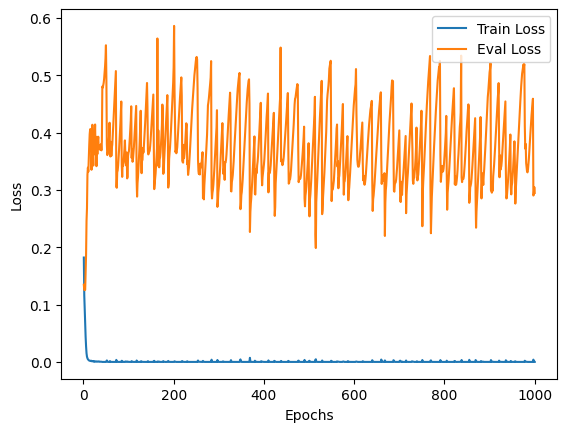

In [8]:
import matplotlib.pyplot as plt

plt.plot(range(1, n_epoch + 1), train_losses, label='Train Loss')
plt.plot(range(1, n_epoch + 1), test_losses, label='Eval Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

[[16093   317]
 [  426  4792]]


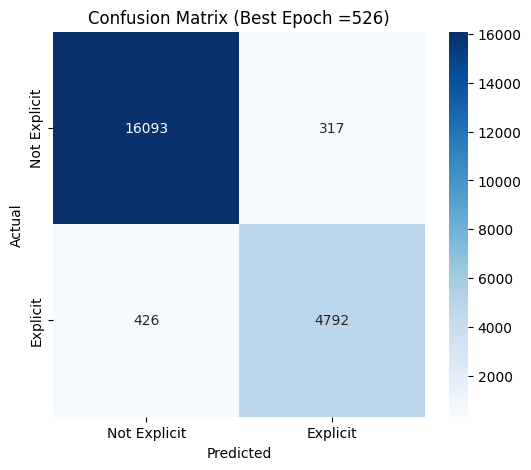

Accuracy:  0.9656
Precision: 0.9380
Recall:    0.9184
F1-score:  0.9281


In [9]:
cm = confusion_matrix(best_labels, best_pred)

plt.figure(figsize=(6,5))
print(cm)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Explicit', 'Explicit'],
            yticklabels=['Not Explicit', 'Explicit']
            )
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix (Best Epoch ={best_ephoc})')
plt.show()

acc = accuracy_score(best_labels, best_pred)
prec = precision_score(best_labels, best_pred )
rec = recall_score(best_labels, best_pred)
f1 = f1_score(best_labels, best_pred)

print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1-score:  {f1:.4f}")